In [1]:
import glob
import pathlib
import itertools
import celltypist
import matplotlib as mpl
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from pandas.errors import EmptyDataError 

# %matplotlib inline
from matplotlib import pyplot as plt
mpl.style.use('./bursa.mplstyle')
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)
%load_ext autoreload
%autoreload 2
FIGURE_OUTDIR = '../../analysis/figures/ed figures'
full_df_loc =  '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'


In [2]:

full_df = pd.read_table(full_df_loc, low_memory=False, usecols = ['vdj_sequence',
                                                                  'cdr3',
                                                                  'cdr3_aa',
                                                                  'fwr3',
                                                                  'fwr3_aa',
                                                                  'fwr4_aa',
                                                                  'fwr4',
                                                                  'donor', 
                                                                  'tissue',
                                                                  'c_call',
                                                                  'v_db_call',
                                                                  'j_call',
                                                                  'v_mismatch',
                                                                  'n_umis', 
                                                                  'corr_cycling',
                                                                  'lineage_id'])
full_df = full_df[full_df.vdj_sequence.notna()]

In [3]:
full_df['v_call_simple'] = full_df.v_db_call.fillna("").map(lambda x: x.split("*")[0])
# find position fo conserved cysteine
full_df['C_pos'] = full_df.fwr3_aa.map(lambda x: len(x.split("C")[-1])+1)
# add conserved residues to cdr3
full_df['cdr3_full'] = full_df.apply(lambda x:x.fwr3[-3*(x.C_pos):],axis=1) + full_df['cdr3'] + full_df['fwr4'].map(lambda x:x[:3])
full_df['cdr3_aa_full'] = full_df.apply(lambda x:x.fwr3_aa[-(x.C_pos):],axis=1) + full_df['cdr3_aa'] + full_df['fwr4_aa'].map(lambda x:x[:1])
full_df['clonotype'] = full_df['v_call_simple'] + "|" + full_df['j_call'] + "|" +  full_df['cdr3_aa_full']
single_cdr3_lineages = full_df[(full_df.C_pos<=1) & (full_df.v_mismatch==0)].groupby(['donor','lineage_id'])['cdr3_aa_full'].nunique() ==1 
single_cdr3_lineages = single_cdr3_lineages.to_dict()
in_single_cdr3_lineage = full_df[(full_df.C_pos<=1) & (full_df.v_mismatch==0)].apply(lambda x: single_cdr3_lineages[(x.donor, x.lineage_id)], axis=1)
cdr3_df = full_df[(full_df.C_pos<=1) & (full_df.v_mismatch==0)][in_single_cdr3_lineage].groupby(['cdr3_full','cdr3_aa_full'])['donor'].unique()
cdr3_df = cdr3_df.reset_index()
lineage_id_dict = full_df[full_df.C_pos<=1].groupby(['cdr3_full', 
                                 'donor'])['lineage_id'].unique().to_dict()
cdr3_df['n_donors'] = cdr3_df['donor'].str.len()
cdr3_df['donor'] = cdr3_df.donor.map(lambda x:",".join(x))      

In [4]:
pdf = pd.read_table('../../data/vdj/pgen_marginal.tsv.gz', header=None)
pdf.columns = ['index', 'cdr3_full', 'pgen_nt', 'cdr3_aa_full', 'pgen_aa']
pdf = pdf[['cdr3_full', 'pgen_nt', 'cdr3_aa_full', 'pgen_aa']]
cdr3_df = cdr3_df.merge(pdf, on=['cdr3_full', 'cdr3_aa_full'], how='left')
cdr3_full_dict = full_df.groupby(['vdj_sequence', 'cdr3_full','v_mismatch']).size()
cdr3_full_dict = cdr3_full_dict.reset_index().set_index('vdj_sequence')[['cdr3_full','v_mismatch']].to_dict()
pgen_dict = pdf.set_index('cdr3_full')['pgen_nt'].to_dict()

In [5]:
unique_vdj_seqs = full_df.groupby(['vdj_sequence'])['donor'].unique().map(lambda x: ",".join(sorted(x))).reset_index()
unique_vdj_seqs['n_donors'] = unique_vdj_seqs['donor'].str.split(",").map(lambda x: len(x))
unique_vdj_seqs['cdr3_full'] = unique_vdj_seqs['vdj_sequence'].map(cdr3_full_dict['cdr3_full'])
unique_vdj_seqs['v_mismatch'] = unique_vdj_seqs['vdj_sequence'].map(cdr3_full_dict['v_mismatch'])
unique_vdj_seqs['pgen_nt'] = unique_vdj_seqs['cdr3_full'].map(pgen_dict)
unique_vdj_seqs['pgen_nt'] = unique_vdj_seqs['cdr3_full'].map(pgen_dict)
unique_vdj_seqs['log_pgen_nt'] =np.log(unique_vdj_seqs.pgen_nt)/np.log(10)
unique_vdj_counts = unique_vdj_seqs.groupby(['donor']).size()
multi_donor = unique_vdj_counts.index.str.contains(",")
single_donor = ~multi_donor
sorted_indices = sorted(unique_vdj_counts[single_donor].index) + sorted(unique_vdj_counts[multi_donor].index)
unique_vdj_counts = unique_vdj_counts[sorted_indices]
print(unique_vdj_counts.sum())
unique_vdj_counts

700687


donor
TBd1          60749
TBd2         107194
TBd3          74864
TBd4          34359
TBd5         189651
TBd6         233864
TBd1,TBd2         1
TBd1,TBd3         1
TBd2,TBd6         4
dtype: int64

In [6]:
unique_clonotypes = full_df.groupby(['clonotype'])['donor'].unique().map(lambda x: ",".join(sorted(x))).reset_index()
unique_clonotypes['n_donors'] = unique_clonotypes['donor'].str.split(",").map(lambda x: len(x))
unique_clonotype_counts = unique_clonotypes.groupby(['donor']).size()
multi_donor = unique_clonotype_counts.index.str.contains(",")
single_donor = ~multi_donor
sorted_indices = sorted(unique_clonotype_counts[single_donor].index) + sorted(unique_clonotype_counts[multi_donor].index)
unique_clonotype_counts = unique_clonotype_counts[sorted_indices]
unique_clonotypes.n_donors.value_counts()

1    638333
2       353
3        23
Name: n_donors, dtype: int64

# Simple sharing calc

In [7]:

N = full_df[(full_df.C_pos<=1) & (full_df.v_mismatch==0)].groupby('donor')['cdr3_full'].nunique()
observed_unique_seqs = full_df[(full_df.C_pos<=1) & (full_df.v_mismatch==0)][in_single_cdr3_lineage].groupby('donor')['cdr3_aa_full'].nunique()
observed_unique_seqs['all'] = full_df[(full_df.C_pos<=1) & (full_df.v_mismatch==0)][in_single_cdr3_lineage]['cdr3_aa_full'].nunique()

p_recomb_is_productive = 0.15107851669614453
pgen_aa_dist =np.asarray(sorted(cdr3_df['pgen_aa'].values))

pgen_aa_dist = pgen_aa_dist[pgen_aa_dist > 10**-58]/p_recomb_is_productive
bins = np.logspace(-58,-6,500)
Es = np.abs(np.log(bins))
Es = np.sqrt(Es[1:] * Es[:-1])
dE = np.abs(np.diff(Es)[0])
counts, bins = np.histogram(pgen_aa_dist, bins)
P_of_E = counts/counts.sum()/dE
g_of_E = P_of_E * np.exp(Es)

def M0_numeric(g_of_E, Es, N):
    return (g_of_E * (1 - np.exp(-N * np.exp(-Es)))*dE).sum()
def M0_corrected_numeric(g_of_E, Es, N, x):
    upper_limit = - np.log(x)
    mask = Es >= upper_limit 
    elements = x*(g_of_E * (1 - np.exp(-N/x * np.exp(-Es))))*dE
    return(elements[mask].sum())
N['all'] = N.sum()
qs = np.logspace(-6,0,200)
xs = pd.Series(qs, index=qs)
M_noughts = pd.DataFrame(index=qs)
for donor in N.index:
    new_vals = [M0_corrected_numeric(g_of_E, Es, N[donor], x) for x in xs.values]
    M_noughts[donor] = new_vals
p_productive_sequence_passes_neg_sel = ((M_noughts - observed_unique_seqs)**2).idxmin().mean()
q = p_recomb_is_productive*p_productive_sequence_passes_neg_sel


In [8]:

log_p_absent = pd.DataFrame(index=cdr3_df.index)
log_p_present = pd.DataFrame(index=cdr3_df.index)
log_p_absent_selection = pd.DataFrame(index=cdr3_df.index)
log_p_present_selection = pd.DataFrame(index=cdr3_df.index)
for donor in N.keys():
    log_p_absent[donor] =  -cdr3_df['pgen_nt'] * N[donor]/p_recomb_is_productive
    log_p_present[donor] = np.log(cdr3_df['pgen_nt'] * N[donor]/p_recomb_is_productive)
    log_p_absent_selection[donor] =  -cdr3_df['pgen_nt'] * N[donor]/q
    log_p_present_selection[donor] = np.log(cdr3_df['pgen_nt']/q * N[donor])
    
log_p_at_least_one = np.log(-(np.einsum('ij->i', log_p_absent))+10**-65)
log_p_at_least_one_selection = np.log(-(np.einsum('ij->i', log_p_absent_selection))+10**-65)
                            
M = np.zeros(6)
M_selection = np.zeros(6)

for i in range(len(M)):
    F = 0
    F_selection = 0
    for present in itertools.combinations(list(N.keys()),i+1):
        #sum over all donors
        present = list(present)
        others = [x for x in list(N.keys()) if not (x in present)]
        #product of exponential factors over all sequences
        f =(np.einsum('ij->i', log_p_absent[others]) 
            + np.einsum('ij->i', log_p_present[present]))
        f -= log_p_at_least_one
        f = np.exp(f)
        f = np.sum(f)

        F+= f
        
        f_selection =(np.einsum('ij->i', log_p_absent_selection[others]) 
                      + np.einsum('ij->i', log_p_present_selection[present]))
        f_selection -= log_p_at_least_one_selection
        f_selection = np.exp(f_selection)
        f_selection = np.sum(f_selection)
        F_selection+= f_selection
        
    M[i] = F
    M_selection[i] = F_selection
M = pd.Series(M)
M.index = M.index+1
M_selection = pd.Series(M_selection)
M_selection.index = M_selection.index+1


1    284091
2         8
Name: n_donors, dtype: int64


maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 9 glyphs before
Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'nonmarkingreturn', 'space']
Glyph IDs:   [0, 1, 2, 3, 68, 69, 70, 71, 72]
Closed glyph list over 'GSUB': 9 glyphs after
Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'nonmarkingreturn', 'space']
Glyph IDs:   [0, 1, 2, 3, 68, 69, 70, 71, 72]
Closing glyph list over 'glyf': 9 glyphs before
Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'nonmarkingreturn', 'space']
Glyph IDs:   [0, 1, 2, 3, 68, 69, 70, 71, 72]
Closed glyph list over 'glyf': 9 glyphs after
Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'nonmarkingreturn', 'space']
Glyph IDs:   [0, 1, 2, 3, 68, 69, 70, 71, 72]
Retaining 9 glyphs
head subsetting not needed
hhea subsetting not needed
maxp subsetting not needed
OS/2 subset

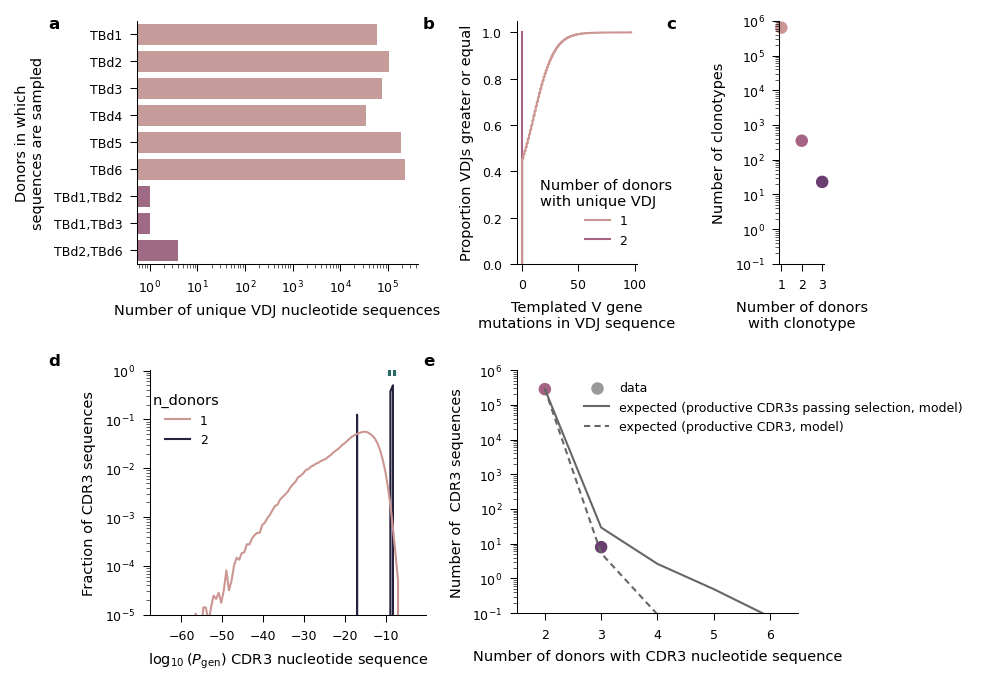

In [10]:
bins = np.linspace(-65,-3,100)
cdr3_df['log_pgen_nt'] = np.log(cdr3_df.pgen_nt)/np.log(10)
cmap_string = "ch:s=-.2,r=.6,l=0.65"
cmap=sns.color_palette(cmap_string, n_colors=4)

g = sns.displot(cdr3_df, x ='log_pgen_nt', 
             hue='n_donors', 
             element='poly',
             bins=bins,
             stat='probability',
             palette=cmap_string,
             common_norm=False,
            fill=False)
counts, bins = np.histogram(unique_vdj_seqs['log_pgen_nt'], bins=bins)

ax= g.axes[0][0]
ax.scatter(unique_vdj_seqs.loc[unique_vdj_seqs.n_donors>1,'log_pgen_nt'],
            [1.]*(unique_vdj_seqs.n_donors>1).sum(), marker='|', color="#266967", linewidths=1)
ax.set_ylim([10**-5, 1.05])
           
ax.set_ylabel('Fraction of CDR3 sequences')
g.axes[0][0].set_yscale('log')
g.figure.set_figwidth(2.5)
g.figure.set_figheight(2.25)
sns.move_legend(g, loc='upper left', frameon=False, bbox_to_anchor=(0.2,0.9))
ax.set_xlabel(r'$\log_{10}(P_\mathrm{gen})$ CDR3 nucleotide sequence')
fig = g.figure
ax = fig.add_axes((1.2,0.215,0.75,0.72))
colors = [cmap[i] for i in cdr3_df.n_donors.value_counts().index]

x = cdr3_df.n_donors.value_counts().index
y=cdr3_df.n_donors.value_counts().values
ax.scatter(x, y, marker='o', 
           color=colors)
ax.scatter([],[],marker='o', color='0.6', label='data')
ax.plot(M_selection, label='expected (productive CDR3s passing selection, model)', color='0.4')

line1, = ax.plot(M, label='expected (productive CDR3, model)', color='0.4')
line1.set_dashes((3,2))

ax.legend(frameon=False, bbox_to_anchor=(0.2,1))
ax.set_yscale('log')
ax.set_xlabel('Number of donors with CDR3 nucleotide sequence')
ax.set_ylabel('Number of  CDR3 sequences')
ax.set_ylim([10**-1,10**6])
ax.set_xticklabels([1,2,3,4,5,6])
ax.set_xlim([0.5,5.5])

ax_vdj = fig.add_axes((0.187,1.25,0.75,0.72))

bar_colors = [cmap[0]]*6 + [cmap[1]]*3
sns.barplot(unique_vdj_counts.reset_index(), x=0, y='donor', ax = ax_vdj, palette=bar_colors)
ax_vdj.set_xscale('log')
ax_vdj.set_xlabel('Number of unique VDJ nucleotide sequences')
ax_vdj.set_ylabel('Donors in which\nsequences are sampled')

ax_characteristics = fig.add_axes((1.2,1.25,0.32,0.72))
g=sns.ecdfplot(unique_vdj_seqs, x='v_mismatch', ax = ax_characteristics, hue='n_donors', palette={1:cmap[0], 2:cmap[1]})
ax_characteristics.set_xlabel('Templated V gene\nmutations in VDJ sequence')
ax_characteristics.set_ylabel('Proportion VDJs greater or equal')
sns.move_legend(g,title='Number of donors\nwith unique VDJ', 
               frameon=False,
               loc='upper left',
               bbox_to_anchor=(.1,.4))
ax_characteristics.set_ylim([0,1.05])

ax_clonotypes = fig.add_axes((1.9,1.25,0.12,0.72))
x = unique_clonotypes.n_donors.value_counts().index
y = unique_clonotypes.n_donors.value_counts().values
colors = [cmap[i-1] for i in unique_clonotypes.n_donors.value_counts().index]
ax_clonotypes.scatter(x, y, marker='o', 
           color=colors, clip_on=False)
ax_clonotypes.set_yscale('log')
ax_clonotypes.set_ylim([10**-1,10**6])
ax_clonotypes.set_yscale('log')
ax_clonotypes.set_ylabel('Number of clonotypes')
ax_clonotypes.set_xlabel('Number of donors\nwith clonotype')

sns.despine(fig)
fig.tight_layout()
fig.text(-0.05, 1.95, 'a', fontsize=8, weight='bold')
fig.text(0.95, 1.95, 'b', fontsize=8, weight='bold')
fig.text(1.6,1.95,'c', fontsize=8, weight='bold')
fig.text(-0.05, 0.95,'d', fontsize=8, weight='bold')
fig.text(0.95, 0.95,'e', fontsize=8, weight='bold')

fig.savefig(f'{FIGURE_OUTDIR}/ED_donor_sharing.pdf', bbox_inches='tight')